In [11]:
# Import necessary libraries
import requests
import json
import time
import numpy as np
import os
import docx
import aiohttp
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, expon
from statistics import mean, stdev
from io import BytesIO
import concurrent.futures

In [12]:
class StatisticsTest:
    @staticmethod
    def test_normality(data):
        _, p_value = stats.shapiro(data)
        return p_value
                

    @staticmethod
    def test_exponential(data):
        loc_estimate = min(data)
        scale_estimate = 1 / np.mean(data)
        _, p_value = stats.kstest(data, 'expon', args=(loc_estimate, scale_estimate))
        return p_value

In [13]:
class StatisticsCalculator:
    @staticmethod
    def calculate_statistic(file_path):
        with open(file_path, 'r', encoding='latin-1') as file:
            query_times = [float(line.strip()) for line in file]

        mean_val = np.mean(query_times)
        median_val = np.median(query_times)
        max_val = np.max(query_times)
        min_val = np.min(query_times)
        variance = np.var(query_times)
        std_dev = np.std(query_times)
        percentile_90 = np.percentile(query_times, 90)
        return mean_val, median_val, max_val, min_val, variance, std_dev, percentile_90
    
    def generate_data_dict(folder_paths, statistic='mean'):
        data_dict = {}

        for folder_path in folder_paths:
            folder_data = {}
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".txt"):
                    file_path = os.path.join(folder_path, file_name)
                    stats = StatisticsCalculator.calculate_statistic(file_path)
                    stats_dict = {
                        'mean': stats[0],
                        'median': stats[1],
                        'max': stats[2],
                        'min': stats[3],
                        'variance': stats[4],
                        'standard_deviation': stats[5],
                        'percentile_90': stats[6]
                    }

                    folder_data[os.path.splitext(file_name)[0]] = stats_dict.get(statistic)

            folder_name = os.path.basename(folder_path).replace('queries_times_', '')
            data_dict[folder_name] = folder_data

        return data_dict
    

In [14]:


class StatisticsGenerator:

    @staticmethod
    def generate_comparison_chart(folder_paths, statistic='mean'):
        data_dict = StatisticsCalculator.generate_data_dict(folder_paths, statistic)

        # Flatten the dictionary to get a list of tuples (folder_name, file_name, stat_value)
        flat_data = [(folder_name, file_name, stat_value) for folder_name, folder_data in data_dict.items() for file_name, stat_value in folder_data.items()]

        # Sort the data alphabetically primarily by file_name and secondarily by folder_name
        sorted_data = sorted(flat_data, key=lambda x: (x[1], x[0]))

        labels = [f"{sorted_data[i][1]}" if i % 3 == 1 else '' for i in range(len(sorted_data))]
        values = [stat_value for _, _, stat_value in sorted_data]
        folder_names = [folder_name for folder_name, _, _ in sorted_data]

        # Sort unique folder names alphabetically for consistency after regenerating
        unique_folder_names = sorted(set(folder_names))
    
        # color_list = ['#24FF00', '#2596BE', '#FFA07A']  # ForestGreen, LightBlue, LightSalmon
        # # Create a color map dictionary based on alphabetical order
        # color_map = {folder_name: color_list[i % len(color_list)] for i, folder_name in enumerate(unique_folder_names)
        # # Assign colors based on alphabetical order
        # colors = [color_map[folder_name] for folder_name in folder_names]

        # Create a color map dictionary based on alphabetical order
        color_map = {folder_name: plt.cm.tab10(i) for i, folder_name in enumerate(unique_folder_names)}
        # Assign colors based on alphabetical order
        colors = [color_map[folder_name] for folder_name in folder_names]

        x = np.arange(len(labels))
        width = 0.82

        fig, ax = plt.subplots(figsize=(10, 5))  # Adjust figure size as needed
        bars = ax.bar(x, values, width, label=statistic.capitalize(), color=colors)
        # Adjust x-axis limits
        ax.set_xlim(min(x) - 0.5, max(x) + 0.5)  # Adjust as needed
        group_width = 3 * width + 0.5 # Total width for a group of 3 bars

        for i, bar in enumerate(bars):
            # Calculate new position
            new_x = (i // 3) * group_width + (i % 3) * width
            bar.set_x(new_x)
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=6.5)

        group_labels = [labels[i+1] for i in range(0, len(labels), 3)]
        ax.set_xticks([(i * group_width) + (group_width / 2 - width / 2) for i in range(len(group_labels))])
        ax.set_ylabel(f'{statistic.capitalize()} Values')
        # ax.set_title(f'Comparison of {statistic.capitalize()}')
        ax.set_title(f'Comparison of CRUD Operations')
        ax.set_xticklabels(group_labels, rotation=45, ha='right')

        # Manually create legend handles with appropriate colors
        legend_handles = [plt.Line2D([0], [0], color=color_map[folder_name], lw=4) for folder_name in unique_folder_names]
        legend_labels = [f'{folder}' for folder in unique_folder_names]

        # Add legend with custom handles and labels
        ax.legend(legend_handles, legend_labels)

        plt.show()

        # Save the plot to a BytesIO object
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png', dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.close()


        return img_buf



    @staticmethod
    def generate_basic_graph(data, filename):
        # Function implementation
        plt.figure()
        plt.plot(data, marker='o', linestyle='-')
        plt.title(f"Basic Graph - {filename}")
        plt.xlabel("Query")
        plt.ylabel("Time (ms)")
        plt.grid(True)
        # Save the plot to a BytesIO object
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png')
        plt.close()

        # Return the BytesIO object
        return img_buf

    @staticmethod
    def generate_histogram(data, filename):
        plt.figure()
        
        # Square Root Rule
        num_bins = int(np.sqrt(len(data)))

        # Plot the histogram
        plt.hist(data, bins=num_bins, color='blue', edgecolor='black', density=True, alpha=0.7, label='Data Histogram')

        # Overlay normal distribution curve
        mu, sigma = mean(data), stdev(data)
        x = np.linspace(min(data), max(data), 100)
        y = norm.pdf(x, mu, sigma)
        plt.plot(x, y, 'r-', linewidth=2, label='Normal Distribution')

        # Overlay exponential distribution curve
        loc, scale = min(data), stdev(data)  # Adjusted scale parameter
        y_exponential = expon.pdf(x, loc, scale)
        plt.plot(x, y_exponential, 'g-', linewidth=2, label='Exponential Distribution')
        
        plt.title(f"Histogram - {filename}")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        plt.grid(True)

        # Save the plot to a BytesIO object
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png')
        plt.close()

        # Return the BytesIO object
        return img_buf


    @staticmethod
    def generate_overall_stats(folder_paths):
        
        overall_doc = docx.Document()
        
        # for stat_type in ['mean', 'variance', 'standard_deviation']:
        for stat_type in ['mean', 'median', 'max', 'min', 'variance', 'standard_deviation', 'percentile_90']:

            # Generate comparison chart and add it to the overall doc
            img_buf = StatisticsGenerator.generate_comparison_chart(folder_paths, statistic=stat_type)
            overall_doc.add_heading(f"Comparison Chart - {stat_type.capitalize()}", level=1)
            overall_doc.add_picture(img_buf, width=docx.shared.Inches(7))
            overall_doc.add_page_break()
        
        # overall_output_path = os.path.join("./", "overall_stats.docx")
        # overall_output_path = folder_paths.join("./", "overall_stats.docx")
        overall_output_path = os.path.join("D:/Documents/Unob_7/STC/STC_code/DB_Performance/_Test/Performance/Test_v3/_code", "overall_stats.docx")
        overall_doc.save(overall_output_path)

    
    @staticmethod
    def generate_stats_docx(folder_paths):
        for folder_path in folder_paths:
            doc = docx.Document()
            doc.add_heading(f"Statistics for Files in {folder_path}", level=1)

            for filename in os.listdir(folder_path):
                if filename.endswith(".txt"):
                    file_path = os.path.join(folder_path, filename)

                    with open(file_path, 'r') as file:
                        content = file.read().splitlines()

                        # Extract numerical data from the file
                        data = [float(line) for line in content if line.strip().replace('.', '').isdigit()]

                        if data:
                            # Basic statistics
                            doc.add_heading(f"File: {filename}", level=2)
                            doc.add_paragraph(f"Number of queries: {round(len(data), 2)}")
                            doc.add_paragraph(f"Mean: {round(np.mean(data), 2)}")
                            doc.add_paragraph(f"Median: {round(np.median(data), 2)}")
                            doc.add_paragraph(f"Max: {round(np.max(data), 2)}")
                            doc.add_paragraph(f"Min: {round(np.min(data), 2)}")
                            doc.add_paragraph(f"Variance: {round(np.var(data), 2)}")
                            doc.add_paragraph(f"Standard Deviation: {round(np.std(data), 2)}")
                            doc.add_paragraph(f"90th Percentile: {round(np.percentile(data, 90), 2)}")
                            
                            # Perform normality test
                            p_value_normality = StatisticsTest.test_normality(data)
                            doc.add_paragraph(f"Is normal: {'Yes' if p_value_normality > 0.05 else 'No'}")
                            doc.add_paragraph(f"\tShapiro-Wilk test p-value: {p_value_normality}")

                            # Perform exponential distribution test
                            p_value_exponential = StatisticsTest.test_exponential(data)
                            doc.add_paragraph(f"Is exponential: {'Yes' if p_value_exponential > 0.05 else 'No'}")
                            doc.add_paragraph(f"\tKolmogorov-Smirnov test p-value: {p_value_exponential}")
                            doc.add_paragraph("\n")

                            #print out the paragraph
                            

                            # Generate basic graph
                            img_buf_basic = StatisticsGenerator.generate_basic_graph(data, filename)
                            doc.add_picture(img_buf_basic, width=docx.shared.Inches(6))

                            # Generate histogram
                            img_buf_histogram = StatisticsGenerator.generate_histogram(data, filename)
                            doc.add_picture(img_buf_histogram, width=docx.shared.Inches(6))
                            doc.add_page_break()

            output_docx_path = os.path.join("D:/Documents/Unob_7/STC/STC_code/DB_Performance/_Test/Performance/Test_v3/_code", "statistics.docx")
            doc.save(output_docx_path)



postgres: {'groupById_1': 215.56169271469116, 'groupById_2': 221.61475896835327, 'userById_1': 216.1294436454773, 'userById_2': 184.61086988449097, 'user_insert': 172.52848148345947, 'user_update': 221.2045431137085}
cockroach: {'groupById_1': 192.43059158325195, 'groupById_2': 197.1367335319519, 'userById_1': 187.59605407714844, 'userById_2': 152.26155996322632, 'user_insert': 154.2586851119995, 'user_update': 198.54947328567505}
yugabyte: {'groupById_1': 262.14351177215576, 'groupById_2': 317.38396644592285, 'userById_1': 233.7039875984192, 'userById_2': 262.16280221939087, 'user_insert': 203.31344842910767, 'user_update': 282.1241021156311}


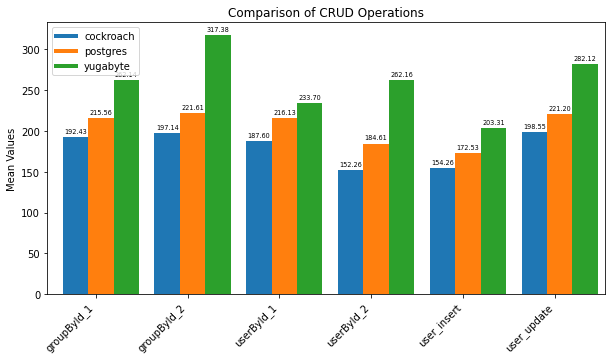

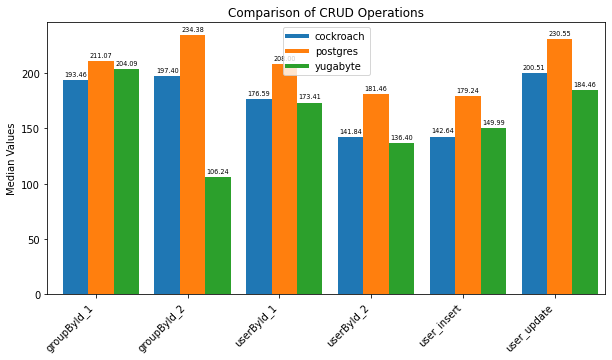

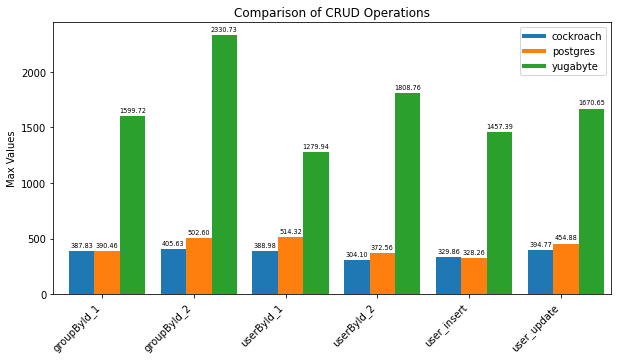

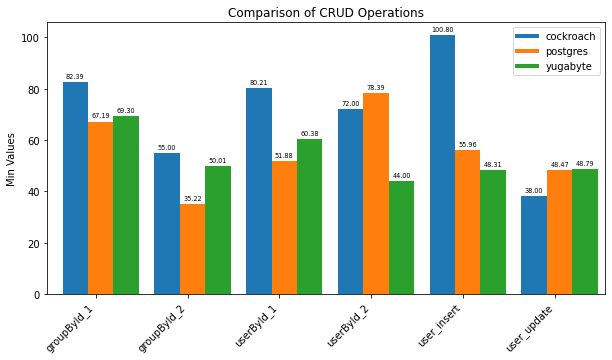

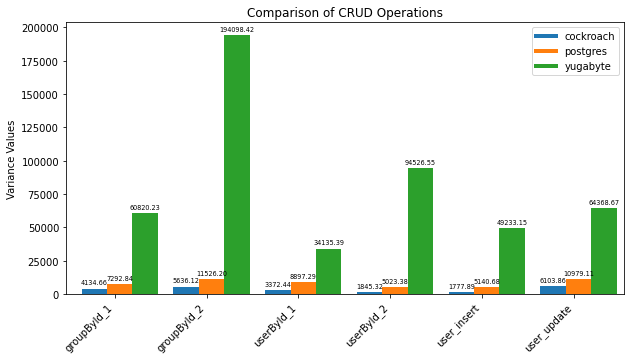

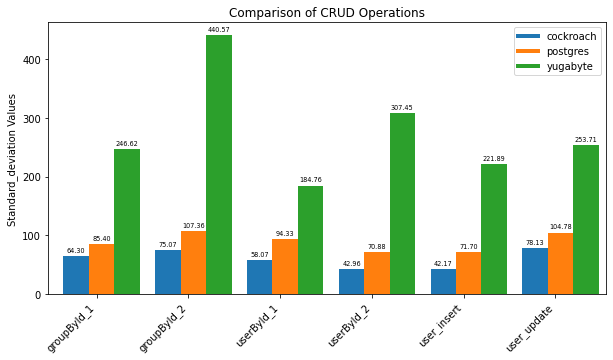

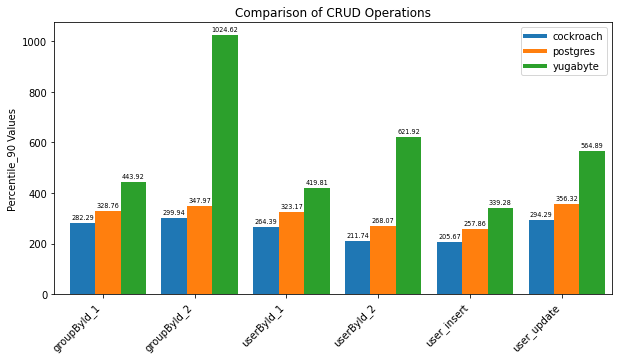

In [15]:
folder_path_1 = 'D:/Documents/Unob_7/STC/STC_code/DB_Performance/_Test/Performance/Test_v3/postgres'
folder_path_2 = 'D:/Documents/Unob_7/STC/STC_code/DB_Performance/_Test/Performance/Test_v3/cockroach'
folder_path_3 = 'D:/Documents/Unob_7/STC/STC_code/DB_Performance/_Test/Performance/Test_v3/yugabyte'

folder_paths = [folder_path_1, folder_path_2, folder_path_3]

data_dict = StatisticsCalculator.generate_data_dict(folder_paths, 'mean')
for db, data in data_dict.items():
    print(f'{db}: {data}')
StatisticsGenerator.generate_overall_stats(folder_paths)      
